# Task 2 Clustering
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to cluster the data

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from prettytable import PrettyTable
from tqdm import tqdm
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata

Import DataFrame of generated user indicators (with excluded features due to high correlation)

In this clustering trial **we do not use entropy features**

In [48]:
df = pd.read_csv("../dataset/user_indicators_uncorrelated.csv") 
df.head(10)

user_id lang  bot           created_at  statuses_count  tweet_count  \
0  2353593986   en    1  2019-02-22 18:00:42              76          127   
1  2358850842   en    0  2019-02-26 03:02:32              54          119   
2   137959629   en    1  2015-04-30 07:09:56               3            4   
3   466124818   it    1  2017-01-18 02:49:18              50         1394   
4  2571493866   en    0  2019-06-18 19:30:21            7085         3535   
5  2199062688   en    0  2018-11-19 06:58:18            7406         1989   
6  1174869769   en    1  2018-02-15 10:51:28              21           24   
7  3118659848   en    0  2020-03-31 21:19:59             115          130   
8   616225564   en    0  2017-06-25 15:49:36            2041           58   
9  2357425536   en    1  2019-02-25 04:30:56              69          144   

   avg_text_len  entropy_minute  entropy_day  post_in_2012  ...  post_in_2020  \
0     62.378788        2.535773     1.227162             0  ...             0   
1     68.762295        2.302317     1.281955             0  ...             0   
2     19.250000        4.000000     1.265081             0  ...             0   
3     86.763030        7.495216     0.347218             0  ...             0   
4     72.214442        5.999865     0.000000             0  ...          3656   
5     45.100913        5.677881     0.265405             0  ...          1747   
6     64.041667        4.175736     2.750914             0  ...             0   
7     62.400000        5.602282     0.719549             0  ...           135   
8     66.883333        5.153498     3.087111             0  ...             0   
9     64.286667        2.239529     1.180164             0  ...             0   

   years_outside_of_plausible_range  creation_year  reply_count_avg  \
0                                 0           2019         0.000000   
1                                 0           2019         0.000000   
2                                 0           2015         0.000000   
3                                 0           2017         0.000000   
4                                 0           2019         0.000000   
5                                 0           2018         0.000000   
6                                 0           2018         0.000000   
7                                 0           2020         0.000000   
8                                 0           2017         0.016667   
9                                 0           2019         0.000000   

   favorite_count_avg  num_hashtags_avg  num_urls_avg  num_mentions_avg  \
0            0.037879          0.098485      0.000000          0.272727   
1            0.049180          0.024590      0.000000          0.336066   
2            0.000000          0.000000      0.000000          0.000000   
3            0.166782          0.073662      0.022238          0.006254   
4            0.056072          0.117888      0.000821          0.505470   
5            0.735704          0.024027      0.022585          0.928400   
6           94.666667          0.458333      0.125000          0.125000   
7            0.925926          0.111111      0.088889          0.807407   
8            0.050000          0.233333      0.033333          0.016667   
9            0.033333          0.100000      0.000000          0.340000   

   retweet_count_sum  favorite_count_sum  
0                  5                   5  
1                  3                   6  
2                  0                   0  
3               1190                 240  
4                 62                 205  
5             819284                1531  
6              15124                2272  
7             417191                 125  
8               4191                   3  
9                  6                   5  

[10 rows x 27 columns]

Convert to logscale some columns with few exceptionally high values

In [49]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           11508 non-null  int64  
 1   lang                              11508 non-null  object 
 2   bot                               11508 non-null  int64  
 3   created_at                        11508 non-null  object 
 4   statuses_count                    11508 non-null  int64  
 5   tweet_count                       11508 non-null  int64  
 6   avg_text_len                      11508 non-null  float64
 7   entropy_minute                    11508 non-null  float64
 8   entropy_day                       11508 non-null  float64
 9   post_in_2012                      11508 non-null  int64  
 10  post_in_2013                      11508 non-null  int64  
 11  post_in_2014                      11508 non-null  int64  
 12  post

Save bot column for final analysis

In [50]:
df_bot = df.bot.copy()

Define colors for bot attribute for plot consistency

In [51]:
dict_colors_bot = { 1: 'teal', 0: 'sandybrown'}

Convert to logscale some columns with few exceptionally high values

In [52]:
df.statuses_count = np.log(df.statuses_count + 1)
df.favorite_count_avg = np.log(df.favorite_count_avg  + 1)
df.favorite_count_sum = np.log(df.favorite_count_sum + 1)
df.retweet_count_sum = np.log(df.retweet_count_sum + 1)
df.reply_count_avg = np.log(df.reply_count_avg + 1)

Exclude some user specific features that are not useful or no to be used in clustering

In [53]:
cat_feature = df[['user_id', 'lang', 'created_at']]
del df['user_id']
del df['lang']
del df['created_at']
del df['bot']
df.head()

statuses_count  tweet_count  avg_text_len  entropy_minute  entropy_day  \
0        4.343805          127     62.378788        2.535773     1.227162   
1        4.007333          119     68.762295        2.302317     1.281955   
2        1.386294            4     19.250000        4.000000     1.265081   
3        3.931826         1394     86.763030        7.495216     0.347218   
4        8.865876         3535     72.214442        5.999865     0.000000   

   post_in_2012  post_in_2013  post_in_2014  post_in_2015  post_in_2016  ...  \
0             0             0             0             0             0  ...   
1             0             0             0             0             0  ...   
2             0             0             0             0             4  ...   
3             0             0             0             0             0  ...   
4             0             0             0             0             0  ...   

   post_in_2020  years_outside_of_plausible_range  creation_year  \
0             0                                 0           2019   
1             0                                 0           2019   
2             0                                 0           2015   
3             0                                 0           2017   
4          3656                                 0           2019   

   reply_count_avg  favorite_count_avg  num_hashtags_avg  num_urls_avg  \
0              0.0            0.037179          0.098485      0.000000   
1              0.0            0.048009          0.024590      0.000000   
2              0.0            0.000000          0.000000      0.000000   
3              0.0            0.154250          0.073662      0.022238   
4              0.0            0.054557          0.117888      0.000821   

   num_mentions_avg  retweet_count_sum  favorite_count_sum  
0          0.272727           1.791759            1.791759  
1          0.336066           1.386294            1.945910  
2          0.000000           0.000000            0.000000  
3          0.006254           7.082549            5.484797  
4          0.505470           4.143135            5.327876  

[5 rows x 23 columns]

## Clustering Preprocessing - Normalization  
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max.

We tried both normalizations to be used in subsequent clusterings.

In [54]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df.values)

In [55]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(df.values)

# DBSCAN

Function that shows graph of k-th nearest neighbour diastance in in order to use Knee Method to estimate the best eps. Multiple values of k are used.

In [56]:
def calc_k_nn_dist_graph(X):
    # List of k (for k-th nearest neighbour)
    k_list = [3, 6, 9, 12]

    dist = pdist(X, 'euclidean') #pair wise distance
    dist = squareform(dist) #distance matrix given the vector dist
    
    # Calculate sorted list of distances for points for each k
    for k in k_list:
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        # Plot the graph of distance from k-th nearest neighbour
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=22)
        plt.grid()
        f = plt.figure()
        f.set_figwidth(4)
        f.set_figheight(1)
        plt.show()

Function that returns a nested list of fitted DBSCANs, one for each combination of eps and minpts values that are passed as lists.

In [57]:
def db_scan_function (X, eps_list, minpts_list, max_iter_value=300):
    # Table with dim = len(eps_list) x len(minpts)
    dbscan_table = list()

    # Iterate over eps (rows)
    for i, eps in tqdm(enumerate(eps_list)):
        dbscan_table.append([]) 
        # Iterate over minpts
        for minpts in tqdm(minpts_list, leave=False):
            dbscan = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1)
            dbscan.fit(X)
            dbscan_table[i].append(dbscan)
    
    return dbscan_table

#### DBSCAN with **minmax normalization**

k-th nn graphs

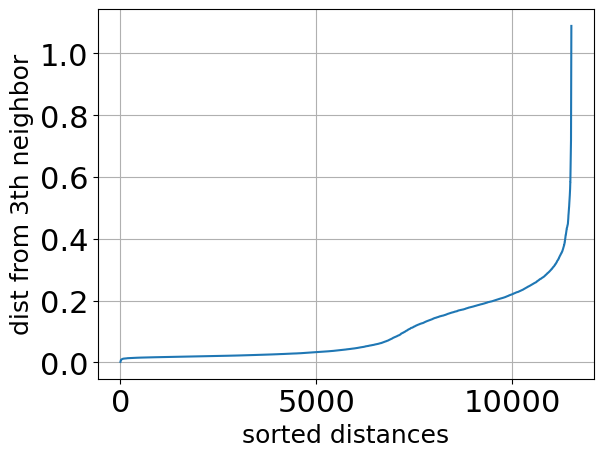

<Figure size 400x100 with 0 Axes>

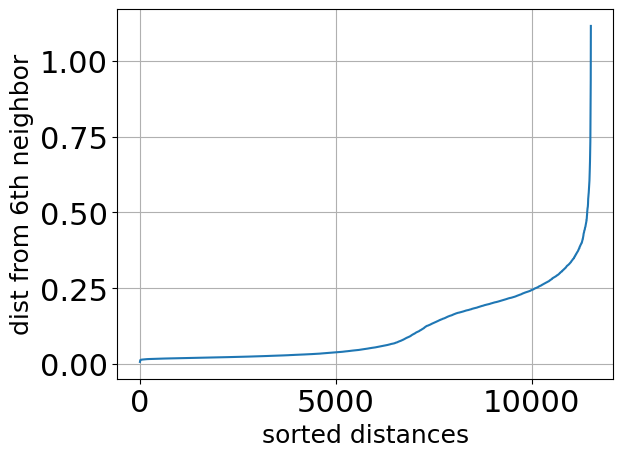

<Figure size 400x100 with 0 Axes>

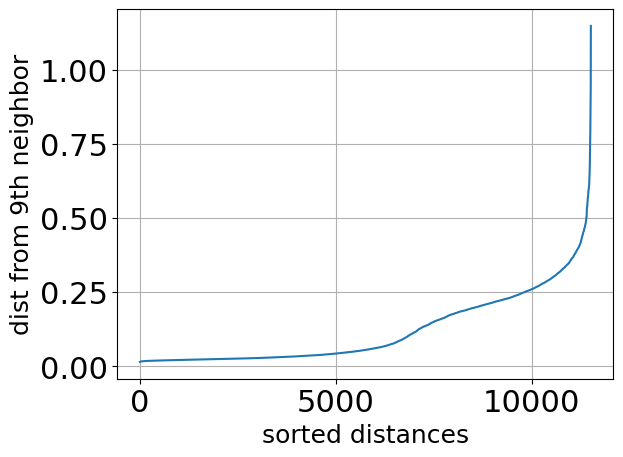

<Figure size 400x100 with 0 Axes>

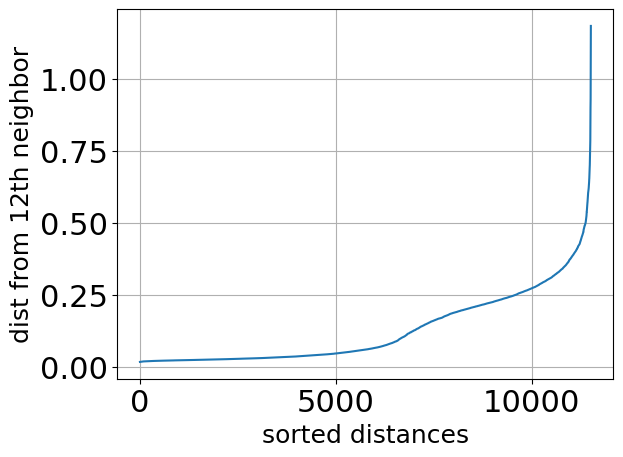

<Figure size 400x100 with 0 Axes>

In [58]:
calc_k_nn_dist_graph(X_minmax)

We select values for eps around 0.1-0.25 according to the knee method

Fit DBSCANs with MINMAX normalization

In [59]:
eps_list = [0.2, 0.25, 0.3, 0.35, 0.4] # min max vals
minpts_list = [5, 10, 15] # min-max vals

# Table with fitted dbscans (rows are eps values, cols are minpts values)
dbscan_table_minmax = db_scan_function(X_minmax, eps_list, minpts_list)

5it [01:23, 16.64s/it]


Calculate and print Silhouette for each DBSCAN

In [60]:
t = PrettyTable()
t.field_names = ['eps\minpts'] + minpts_list

for i, eps in tqdm(enumerate(eps_list)):
    row_str = [str(eps)]
    for j, minpts  in tqdm(enumerate(minpts_list), leave=False):
        dbscan = dbscan_table_minmax[i][j]

        try: # Exception in case of num_clusters=1
            silhouette = round(silhouette_score(X_minmax, dbscan.labels_), 2)
        except:
            silhouette = np.nan
        cell_str = str(silhouette) + '-n_clust:'+str(len(np.unique(dbscan.labels_))-1)
        row_str.append(cell_str)

    t.add_row(row_str)

print('MINMAX normalization \n')
print(t)

5it [00:52, 10.44s/it]

MINMAX normalization 

+------------+------------------+-----------------+-----------------+
| eps\minpts |        5         |        10       |        15       |
+------------+------------------+-----------------+-----------------+
|    0.2     | -0.18-n_clust:18 | 0.04-n_clust:15 | 0.12-n_clust:11 |
|    0.25    | -0.1-n_clust:15  | 0.11-n_clust:10 |  0.19-n_clust:5 |
|    0.3     |  0.14-n_clust:9  |  0.16-n_clust:9 |  0.19-n_clust:8 |
|    0.35    |  0.25-n_clust:3  |  0.1-n_clust:3  |  0.21-n_clust:6 |
|    0.4     |  0.27-n_clust:1  |  0.28-n_clust:1 |  0.26-n_clust:2 |
+------------+------------------+-----------------+-----------------+


Print number elem for each cluster for each DBSCAN

In [61]:
print('MINMAX normalization - count of elements for each cluster\n')

for i, eps in enumerate(eps_list):
    for j, minpts  in enumerate(minpts_list):
        dbscan = dbscan_table_minmax[i][j]
        n_clusters = len(np.unique(dbscan.labels_))-1 # -1 to exclude outlier label
        occ_list = []
        for k in range(-1, n_clusters):
             occ_list.append(np.count_nonzero(dbscan.labels_ == k))
        print('eps:', eps, ', minpts:', minpts, '-', occ_list)

MINMAX normalization - count of elements for each cluster

eps: 0.2 , minpts: 5 - [1642, 8180, 872, 119, 31, 21, 395, 83, 62, 10, 5, 9, 13, 5, 17, 26, 5, 8, 5]
eps: 0.2 , minpts: 10 - [2035, 5929, 867, 1873, 119, 31, 395, 83, 14, 62, 20, 10, 31, 16, 13, 10]
eps: 0.2 , minpts: 15 - [2356, 5911, 864, 1623, 119, 29, 395, 83, 62, 21, 30, 15]
eps: 0.25 , minpts: 5 - [774, 9200, 939, 29, 12, 408, 4, 16, 10, 22, 10, 14, 15, 41, 6, 8]
eps: 0.25 , minpts: 10 - [979, 9059, 939, 406, 12, 29, 20, 10, 14, 30, 10]
eps: 0.25 , minpts: 15 - [1148, 8971, 937, 406, 27, 19]
eps: 0.3 , minpts: 5 - [373, 9611, 945, 92, 437, 12, 25, 3, 4, 6]
eps: 0.3 , minpts: 10 - [483, 9485, 944, 61, 428, 18, 24, 11, 43, 11]
eps: 0.3 , minpts: 15 - [606, 9413, 944, 426, 21, 36, 33, 15, 14]
eps: 0.35 , minpts: 5 - [167, 11301, 32, 8]
eps: 0.35 , minpts: 10 - [239, 11226, 30, 13]
eps: 0.35 , minpts: 15 - [299, 10589, 63, 441, 31, 29, 56]
eps: 0.4 , minpts: 5 - [91, 11417]
eps: 0.4 , minpts: 10 - [121, 11387]
eps: 0.4 , minp

#### DBSCAN with **standard scaler**

k-th nn graphs

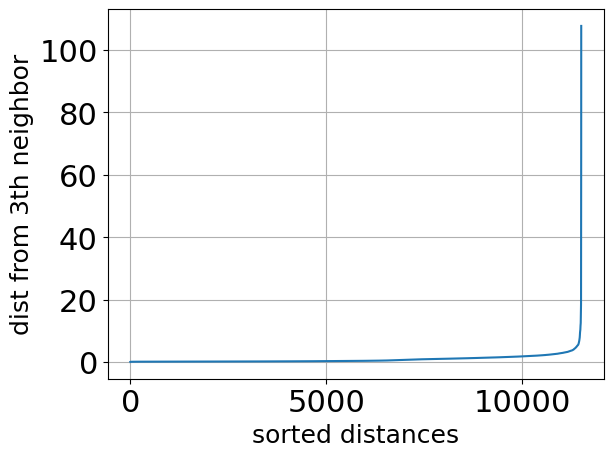

<Figure size 400x100 with 0 Axes>

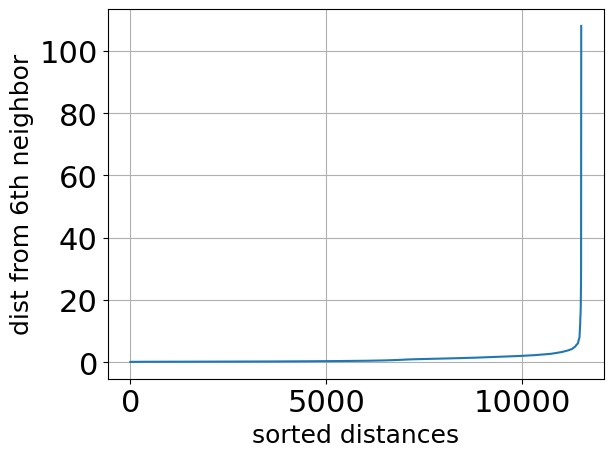

<Figure size 400x100 with 0 Axes>

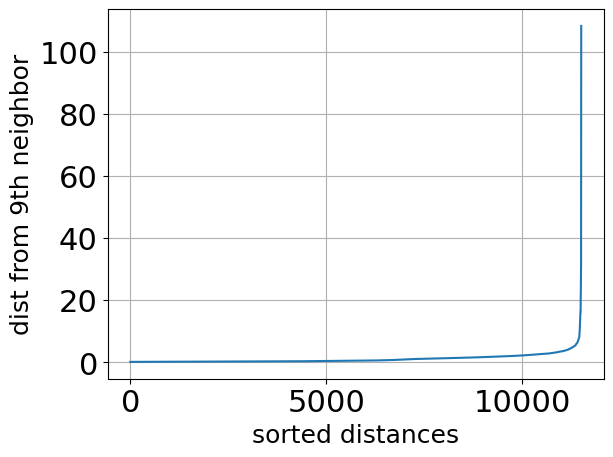

<Figure size 400x100 with 0 Axes>

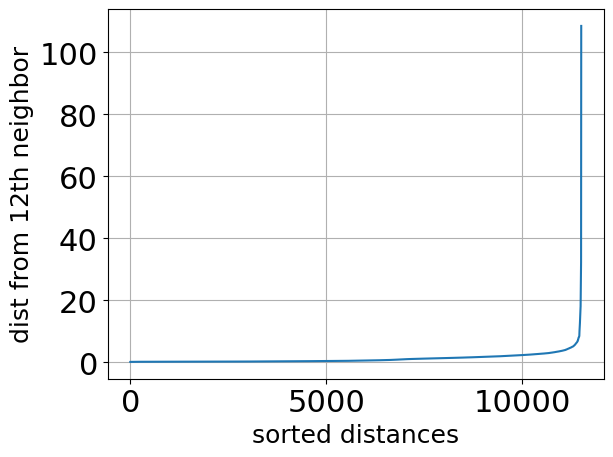

<Figure size 400x100 with 0 Axes>

In [62]:
calc_k_nn_dist_graph(X_std)

TODO: migliora grafico knn distances (cutoff a 20,  grid o yticks).
According to the Knee Method, we experimented with eps values in the range 0.5-3.

Fit DBSCANs with STD/MEAN normalization

In [63]:
eps_list = [2, 2.5, 3, 3.5, 4, 4.5, 5] 
minpts_list = [5, 10, 15] 

# Table with fitted dbscans (rows are eps values, cols are minpts values)
dbscan_table_std = db_scan_function(X_std, eps_list, minpts_list)

7it [02:20, 20.11s/it]


Calculate and print Silhouette for each DBSCAN

In [64]:
t = PrettyTable()
t.field_names = ['eps\minpts'] + minpts_list


for i, eps in enumerate(eps_list):
    row_str = [str(eps)]
    for j, minpts  in enumerate(minpts_list):
        dbscan = dbscan_table_std[i][j]

        try: # Exception in case of num_clusters=1
            silhouette = round(silhouette_score(X_std, dbscan.labels_), 2)
        except:
            silhouette = np.nan
        cell_str = str(silhouette) + '-n_clust:'+str(len(np.unique(dbscan.labels_))-1)
        row_str.append(cell_str)
    t.add_row(row_str)

print('STD normalization\n')
print(t)

STD normalization

+------------+-----------------+----------------+----------------+
| eps\minpts |        5        |       10       |       15       |
+------------+-----------------+----------------+----------------+
|     2      | 0.14-n_clust:20 | 0.2-n_clust:10 | 0.29-n_clust:5 |
|    2.5     |  0.28-n_clust:9 | 0.39-n_clust:4 | 0.31-n_clust:3 |
|     3      |  0.31-n_clust:9 | 0.57-n_clust:2 | 0.56-n_clust:2 |
|    3.5     |  0.5-n_clust:5  | 0.38-n_clust:3 | 0.6-n_clust:2  |
|     4      |  0.57-n_clust:2 | 0.59-n_clust:2 | 0.59-n_clust:2 |
|    4.5     |  0.57-n_clust:2 | 0.71-n_clust:1 | 0.7-n_clust:1  |
|     5      |  0.76-n_clust:1 | 0.74-n_clust:1 | 0.73-n_clust:1 |
+------------+-----------------+----------------+----------------+


Print number elem for each cluster for each DBSCAN

In [65]:
print('STD normalization - count of elements for each cluster\n')

for i, eps in enumerate(eps_list):
    for j, minpts  in enumerate(minpts_list):
        dbscan = dbscan_table_std[i][j]
        occ_list = []
        n_clusters = len(np.unique(dbscan.labels_))-1 # -1 to exclude outlier label
        for k in range(-1, n_clusters):
             occ_list.append(np.count_nonzero(dbscan.labels_ == k))
        print('eps:', eps, ', minpts:', minpts, '-', occ_list)

STD normalization - count of elements for each cluster

eps: 2 , minpts: 5 - [1001, 9824, 55]
eps: 2 , minpts: 10 - [1222, 9685, 51]
eps: 2 , minpts: 15 - [1419, 9568, 44]
eps: 2.5 , minpts: 5 - [584, 10856, 5]
eps: 2.5 , minpts: 10 - [736, 10734, 14]
eps: 2.5 , minpts: 15 - [839, 10117, 144]
eps: 3 , minpts: 5 - [361, 11072, 5]
eps: 3 , minpts: 10 - [465, 11019, 24]
eps: 3 , minpts: 15 - [492, 10995, 21]
eps: 3.5 , minpts: 5 - [218, 11245, 24]
eps: 3.5 , minpts: 10 - [302, 11172, 24]
eps: 3.5 , minpts: 15 - [344, 11142, 22]
eps: 4 , minpts: 5 - [147, 11352, 9]
eps: 4 , minpts: 10 - [190, 11288, 30]
eps: 4 , minpts: 15 - [219, 11258, 31]
eps: 4.5 , minpts: 5 - [110, 11389, 9]
eps: 4.5 , minpts: 10 - [142, 11366, 0]
eps: 4.5 , minpts: 15 - [160, 11348, 0]
eps: 5 , minpts: 5 - [91, 11417, 0]
eps: 5 , minpts: 10 - [109, 11399, 0]
eps: 5 , minpts: 15 - [120, 11388, 0]


After looking at the results of DBSCAN for both normalizations, we noted that DBSCAN fails to perform clustering on our dataset.

Although we are able to reach high Silhouette scores, in all model there is one big cluster containig 99% of the samples, while the eventual others are much smaller, smaller in size than even the number of outliers.

### Outliers identification

We decided to use DBSCAN for outlier identification, so that outliers will be excluded from the inputs of the next clustering algorithms, in order to obtain better performances in clustering.

In [112]:
dbscan_outliers = dbscan_table_std[2][2].labels_

# Get input of only non outlier samples
X_minmax_rem_outliers = X_minmax[dbscan_outliers != -1]
X_std_rem_outliers = X_std[dbscan_outliers != -1]
# Get bot labels of only non outlier samples
df_bot_rem_outliers = df_bot.loc[dbscan_outliers != -1].copy()
# Get initial dataframe of only non outlier samples
df_rem_outliers = df.loc[dbscan_outliers != -1].copy()

In [74]:
# Outliers how many bots
df_bot_outliers = df_bot.loc[dbscan_outliers == -1].copy()
df_bot_outliers.value_counts()

0    309
1    183
Name: bot, dtype: int64

In [75]:
# Remaining how many bots
df_bot_rem_outliers.value_counts()

1    5933
0    5083
Name: bot, dtype: int64

## K-MEANS

For K-Means we chose to use **minmax normalization**, as it is known to be a more suited normalization for this algorithm.

This function returns a set of trained K-Means from a list of possible k values

In [76]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

Now we generate the K-Means clusterings and evaluate them.

In [81]:
# Params for kmeans
clusters_list = [x for x in range(1, 15)]
init_value = 10
iter_value = 300

# Get list of kmeans with from the list of possible k
kmeans_list = KMeansFunction (X_minmax_rem_outliers, clusters_list, init_value, iter_value)

# Calculate SSE and Silhouette for each kmeans
sse_list = []
silhouette_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_minmax_rem_outliers, kmeans.labels_)
    except:
        silhouette = np.nan # silhouette returns exception when there is only 1 label
    silhouette_list.append(silhouette)

    print('K:', clusters_list[i], ' - SSE:', kmeans.inertia_, '- SILHOUETTE:', silhouette)


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


K: 1  - SSE: 6103.373928786992 - SILHOUETTE: nan
K: 2  - SSE: 3151.5270647083184 - SILHOUETTE: 0.48936392526106604
K: 3  - SSE: 2369.4140966616774 - SILHOUETTE: 0.4843250401302215
K: 4  - SSE: 1922.9957138794782 - SILHOUETTE: 0.4248844633632418
K: 5  - SSE: 1537.6321767075344 - SILHOUETTE: 0.4503681048646583
K: 6  - SSE: 1330.7238945136235 - SILHOUETTE: 0.473794608062357
K: 7  - SSE: 1146.6701817058718 - SILHOUETTE: 0.474278732689219
K: 8  - SSE: 1047.0219217474912 - SILHOUETTE: 0.48334941863300435
K: 9  - SSE: 972.504318487214 - SILHOUETTE: 0.5026758831925452
K: 10  - SSE: 899.5079798852937 - SILHOUETTE: 0.513220728364935
K: 11  - SSE: 832.3184151914262 - SILHOUETTE: 0.5076569742678065
K: 12  - SSE: 790.7565438953893 - SILHOUETTE: 0.5120179001602535
K: 13  - SSE: 732.3061922372185 - SILHOUETTE: 0.517496430549541
K: 14  - SSE: 698.4373283544157 - SILHOUETTE: 0.5078765670610017


Plot SSE graph

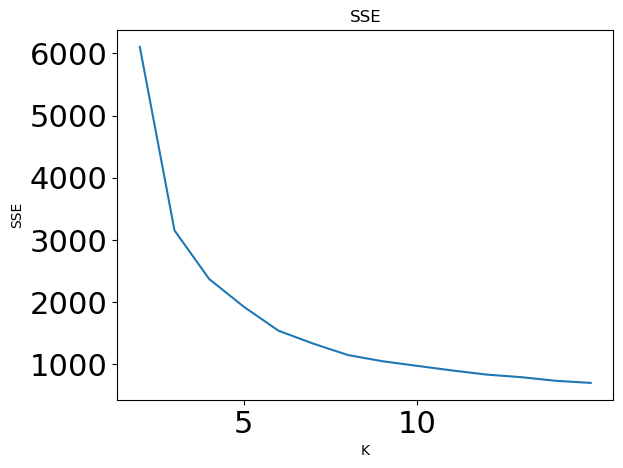

In [82]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.show()

Plot Silhouette graph

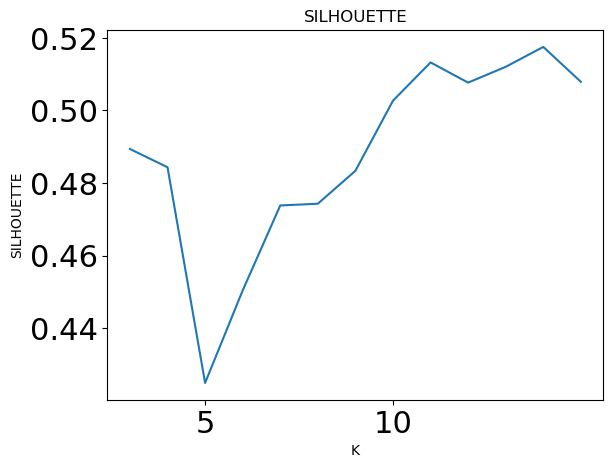

In [83]:
plt.plot(range(2, len(silhouette_list) + 2), silhouette_list)
plt.ylabel('SILHOUETTE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SILHOUETTE')
plt.show()

For K-Means, after analyizing SSE and Silhouette, we selected K=5, as it is approximately at the last significant SSE decrease in the SSE graph, while mantaining a relatively high Silhouette.

In [88]:
final_kmeans = kmeans_list[10]

### Further analysis of final K-Means

Plot of cluster labels distribution

In [89]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(final_kmeans.labels_))

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(final_kmeans.labels_ == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [733, 880, 893, 3428, 842, 441, 634, 266, 512, 856, 1531]


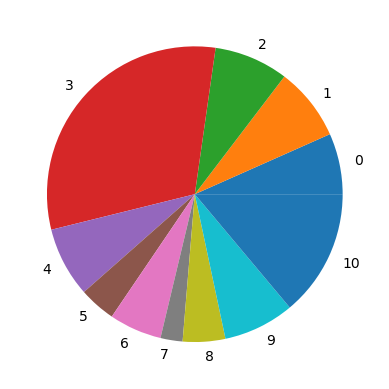

In [90]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

Show scatter plot

In [94]:
if 'labels' in df_rem_outliers.columns:
    del df_rem_outliers['labels']
df_rem_outliers['labels'] = pd.Series(final_kmeans.labels_,index=df_rem_outliers.index)

In [96]:
sns.pairplot(df,hue='labels', palette=sns.color_palette(n_colors=n_clusters))
plt.show()

KeyError: 'labels'

Bot/non bot distribution for each cluster

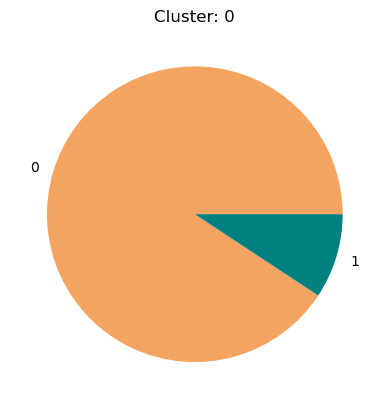

0    665
1     68
Name: bot, dtype: int64


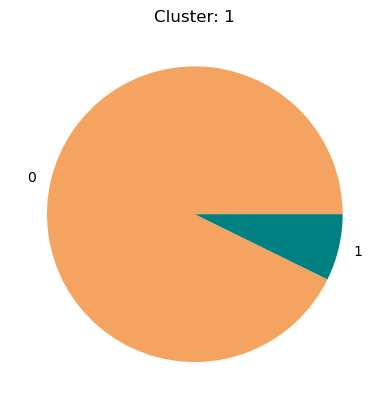

0    816
1     64
Name: bot, dtype: int64


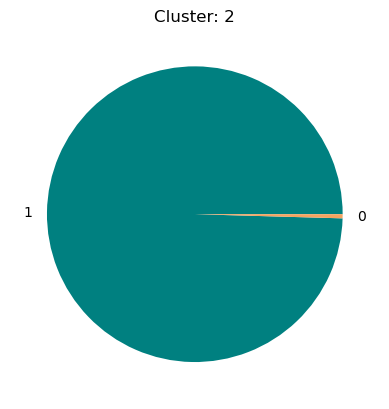

1    889
0      4
Name: bot, dtype: int64


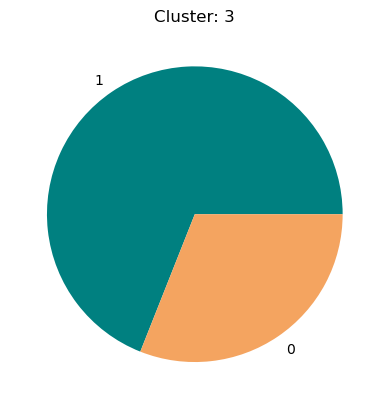

1    2365
0    1063
Name: bot, dtype: int64


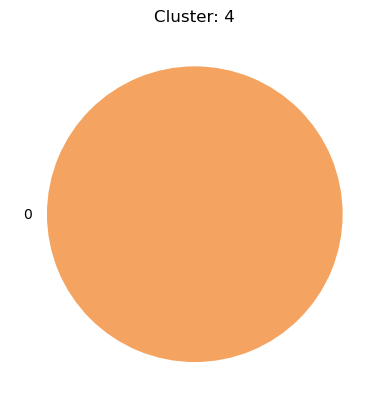

0    842
Name: bot, dtype: int64


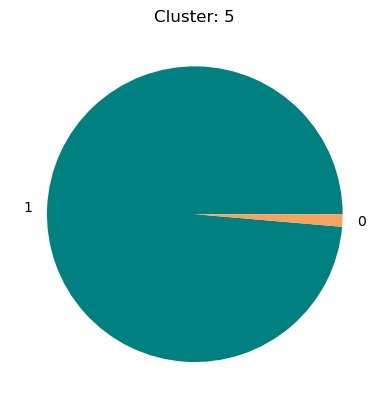

1    435
0      6
Name: bot, dtype: int64


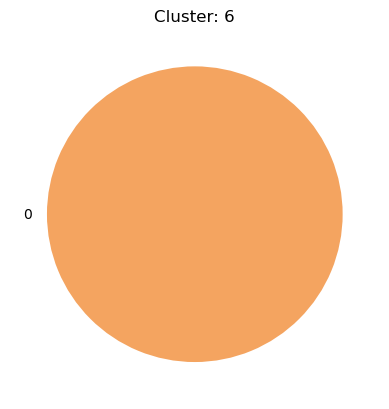

0    634
Name: bot, dtype: int64


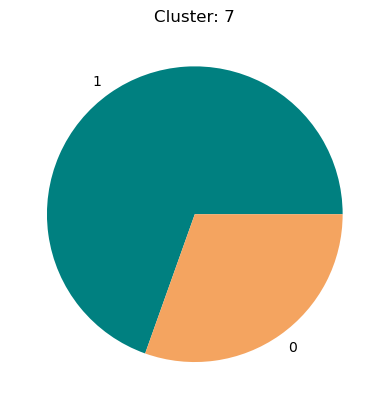

1    185
0     81
Name: bot, dtype: int64


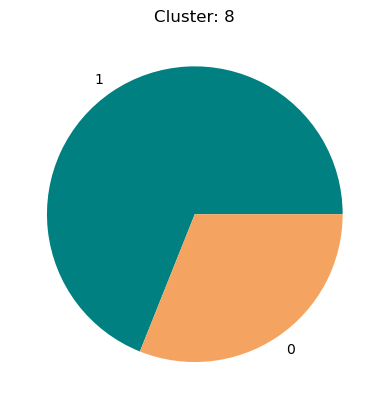

1    353
0    159
Name: bot, dtype: int64


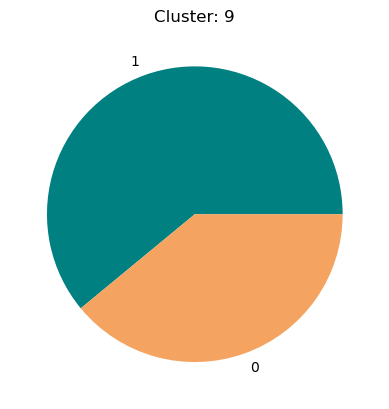

1    522
0    334
Name: bot, dtype: int64


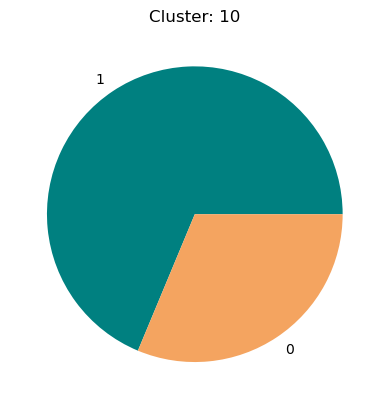

1    1052
0     479
Name: bot, dtype: int64


In [95]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(final_kmeans.labels_))

for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    bot_for_cluster = df_bot_rem_outliers.loc[final_kmeans.labels_ == k].value_counts()
    # Show pie plot
    labels = ['non-bot', 'bot']
    plt.title('Cluster: ' + str(k))
    plt.pie(bot_for_cluster, labels= bot_for_cluster.index, colors=[dict_colors_bot[v] for v in bot_for_cluster.keys()])
    plt.show()
    print(bot_for_cluster)

# Hierarchical

In the following part, we explore agglomerative hierarchical clustering on our dataset.

After some preliminary trials we found that the best distance metric is **cosine**.

We also decided to discard "single" method, as it is sensitive to outliers and in our dataset we did not remove outliers based only on statistical methods. 

After some preliminary trials we also discarded "complete" method, because it failed to generate a meaninigful dendrogram.

Following we report the most significant dendograms of clusterings after having done a coarse selection of hierarchical clustering parameters after preliminary trials.

TODO: threshold selected on maximum length of dendogram branch

### With minmax normalization

In [121]:
config_hierarchical_minamx = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

Method: **ward**, threshold: 5, n_clusters: **5**

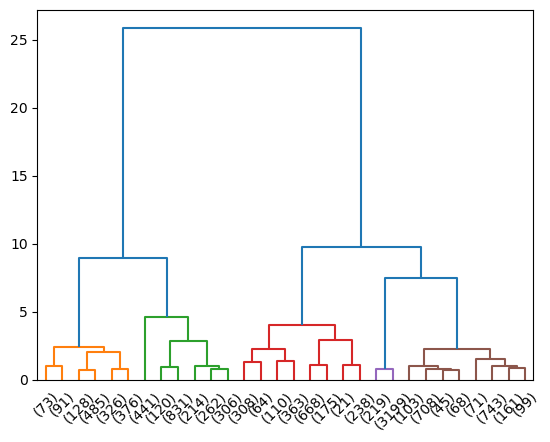

In [122]:
# Generate dendrogram
data_dist = pdist(X_minmax_rem_outliers, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=5, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((5, 'cosine', 'ward'))

Method: **average**, threshold: 0.2, n_clusters: **7**

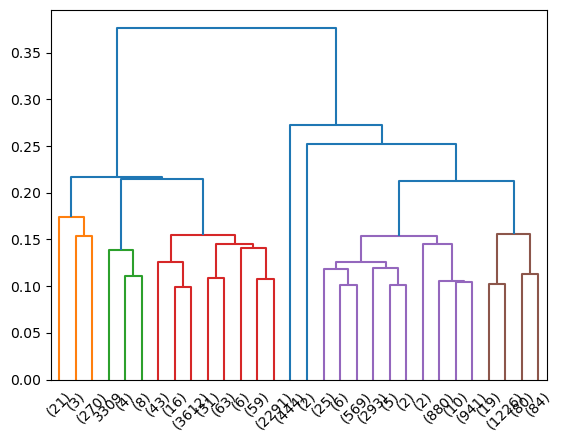

In [123]:
# Generate dendrogram
data_dist = pdist(X_minmax_rem_outliers, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.2, 'cosine', 'average'))

Method: **centroid**, threshold: 0.22, n_clusters: **5**

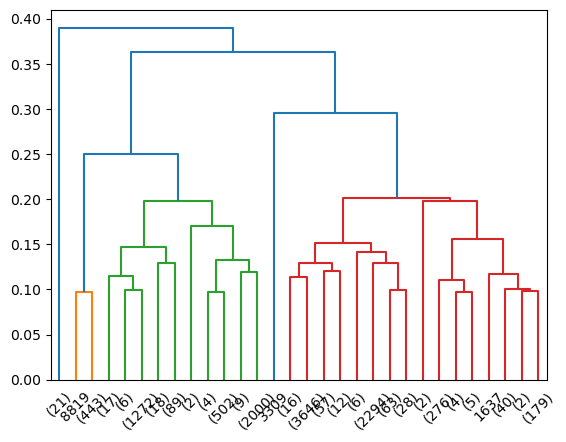

In [124]:
# Generate dendrogram
data_dist = pdist(X_minmax_rem_outliers, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.22, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.22, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [125]:
cluster_list_minmax = []
for treshold, metric_minmax, method_minmax in config_hierarchical_minamx:
    cluster = fclusterdata(X=X_minmax_rem_outliers,
     t=treshold , criterion='distance', metric=metric_minmax, method=method_minmax)
     
    cluster_list_minmax.append(cluster)

Calculate Silhouette for each clustering.

In [126]:
for i, clustering in enumerate(cluster_list_minmax):
    treshold, metric, method = config_hierarchical_minamx[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_minmax_rem_outliers, clustering)
    except:
        silhouette = np.nan
    print("MINMAX - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

MINMAX - dist: cosine , method: ward , SILHOUTTE: 0.43479917889161046 , n_clusters: 5
Clusters Size: [1479, 2174, 1947, 3418, 1998]


MINMAX - dist: cosine , method: average , SILHOUTTE: 0.3333552064287054 , n_clusters: 7
Clusters Size: [294, 13, 6121, 444, 2, 2733, 1409]


MINMAX - dist: cosine , method: centroid , SILHOUTTE: 0.3411952039284435 , n_clusters: 5
Clusters Size: [21, 444, 3919, 6631, 1]




We selected the clusterings with *method: ward** and *n_clusters: 3*, and the one with *method: complete** and *n_clusters: 4*, beacause of the clusters separation in the denrogram and for the absence of small clusters of outlier values. 

Silhouette values are comparable across the last 3 models, with a lower score in the first one.

### With mean-std normalization

In [127]:
config_hierarchical_std = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

Method: **ward**, threshold: 25, n_clusters: **5**

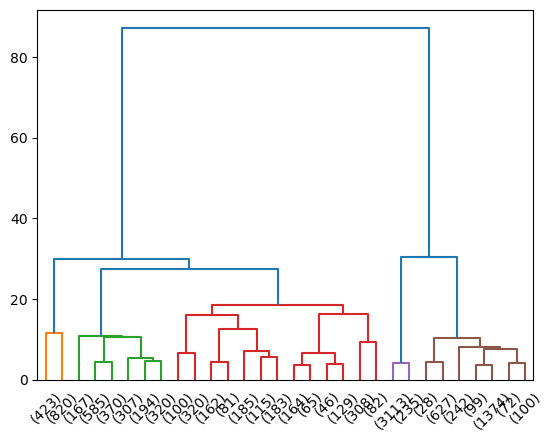

In [128]:
# Generate dendrogram
data_dist = pdist(X_std_rem_outliers, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=25, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((25, 'cosine', 'ward'))

Method: **average**, threshold: 0.95, n_clusters: **4**

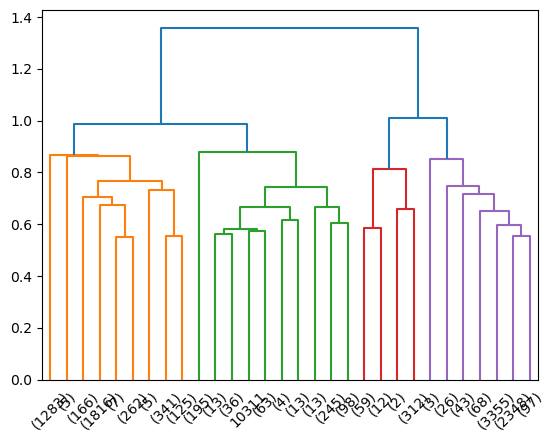

In [129]:
# Generate dendrogram
data_dist = pdist(X_std_rem_outliers, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.95, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.95, 'cosine', 'average'))

Method: **centroid**, threshold: 0.8, n_clusters: **4**

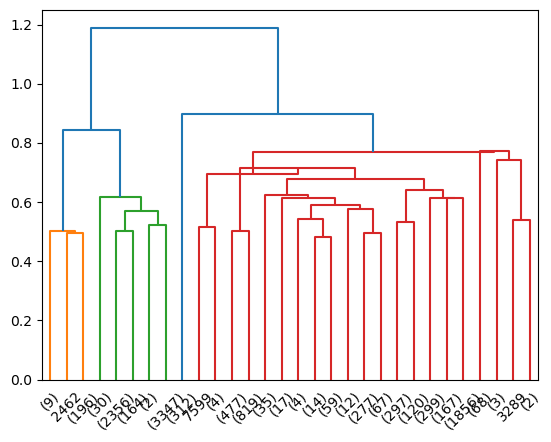

In [130]:
# Generate dendrogram
data_dist = pdist(X_std_rem_outliers, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.8, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.8, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [133]:
cluster_list_std = []
for treshold, metric_std, method_std in config_hierarchical_std:
    cluster = fclusterdata(X=X_std_rem_outliers,
     t=treshold , criterion='distance', metric=metric_std, method=method_std)
     
    cluster_list_std.append(cluster)

Calculate Silhouette for each clustering.

In [134]:
for i, clustering in enumerate(cluster_list_std):
    treshold, metric, method = config_hierarchical_std[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_std_rem_outliers, clustering)
    except:
        silhouette = np.nan
    print("STD - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

STD - dist: cosine , method: ward , SILHOUTTE: 0.35153871631927786 , n_clusters: 5
Clusters Size: [1243, 1943, 1940, 3348, 2542]


STD - dist: cosine , method: average , SILHOUTTE: 0.3739439773442478 , n_clusters: 4
Clusters Size: [4010, 681, 385, 5940]


STD - dist: cosine , method: centroid , SILHOUTTE: 0.36328011528322335 , n_clusters: 4
Clusters Size: [206, 5899, 312, 4599]




We selected 4 clustering among all of the analyzed, based on the goodness of the dendrogram, the number of clusters and the distribution of samples in the clusters. Slihouette was not much significant as it has similar scores across all hierarchical models.

Selcted for further analysis:
1.  MINMAX normalization - dist: cosine, method: ward, n_clusters: 5, silhouette: 0.39
3.  STD normalization - dist: cosine, method: ward, n_clusters: 5, silhouette: 0.31
4.  STD normalization - dist: cosine, method: centroid, n_clusters: 2, silhouette: 0.33

In [140]:
hierarchical_final_ward_minmax = cluster_list_minmax[0] # Hierarchical clustering with 5 clusters
hierarchical_final_ward_std = cluster_list_std[0] # Hierarchical clustering with 5 clusters
hierarchical_final_average_std = cluster_list_std[1] # Hierarchical clustering with 2 clusters

# ATTENTION: CLUSTER LABELS GO FROM 1 TO N_CLUSTERS INSTEAD OF FROM 0 TO N_CLUSTERS-1

### Further analysis of final hierarchical

#### hierarchical_final_ward_minmax

In [141]:
n_clusters = len(np.unique(hierarchical_final_ward_minmax))

Scatter plots

In [144]:
if 'labels' in df.columns:
    del df_rem_outliers['labels']
df_rem_outliers['labels'] = pd.Series(hierarchical_final_ward_minmax,index=df_rem_outliers.index)

In [143]:
sns.pairplot(df_rem_outliers,hue='labels', palette=sns.color_palette(n_colors=n_clusters))
plt.show()

KeyboardInterrupt: 

Bot/non bot distribution for each cluster

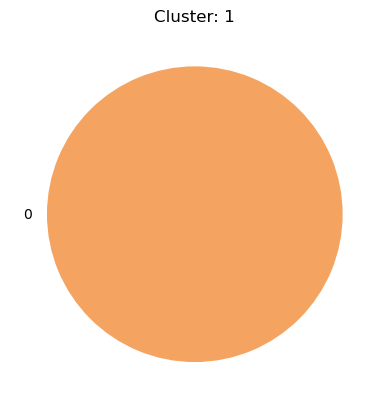

0    1479
Name: bot, dtype: int64


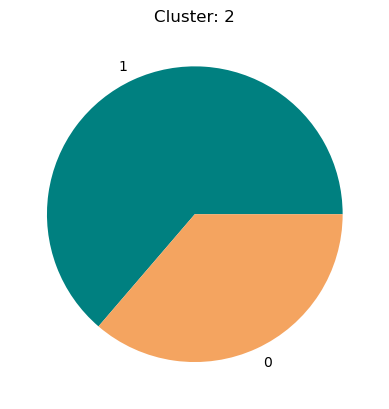

1    1385
0     789
Name: bot, dtype: int64


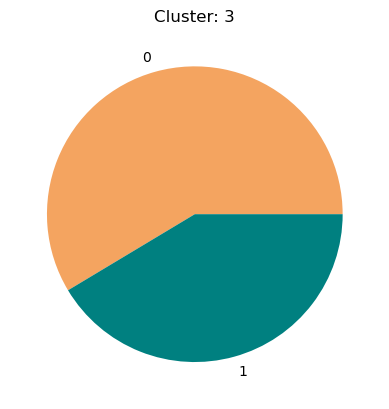

0    1141
1     806
Name: bot, dtype: int64


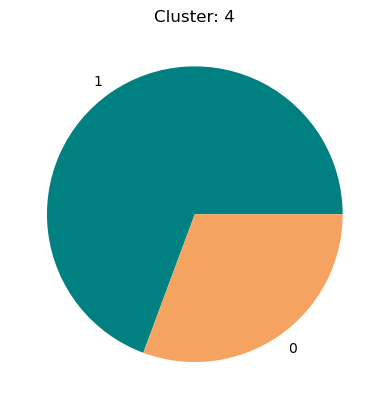

1    2370
0    1048
Name: bot, dtype: int64


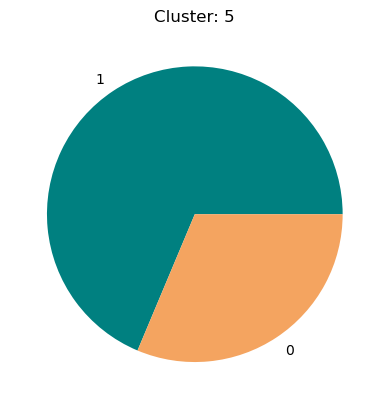

1    1372
0     626
Name: bot, dtype: int64


In [146]:
for k in range(1, n_clusters+1):
    # Get 'bot' values for elems in cluster k
    bot_for_cluster = df_bot_rem_outliers.loc[hierarchical_final_ward_minmax == k].value_counts()
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(bot_for_cluster, labels= bot_for_cluster.index, colors=[dict_colors_bot[v] for v in bot_for_cluster.keys()])
    plt.show()
    print(bot_for_cluster)

#### hierarchical_final_average_minmax

In [ ]:
n_clusters = len(np.unique(hierarchical_final_average_minmax))

Scatter plots

In [ ]:
if 'labels' in df.columns:
    del df['labels']
df['labels'] = pd.Series(hierarchical_final_average_minmax,index=df.index)

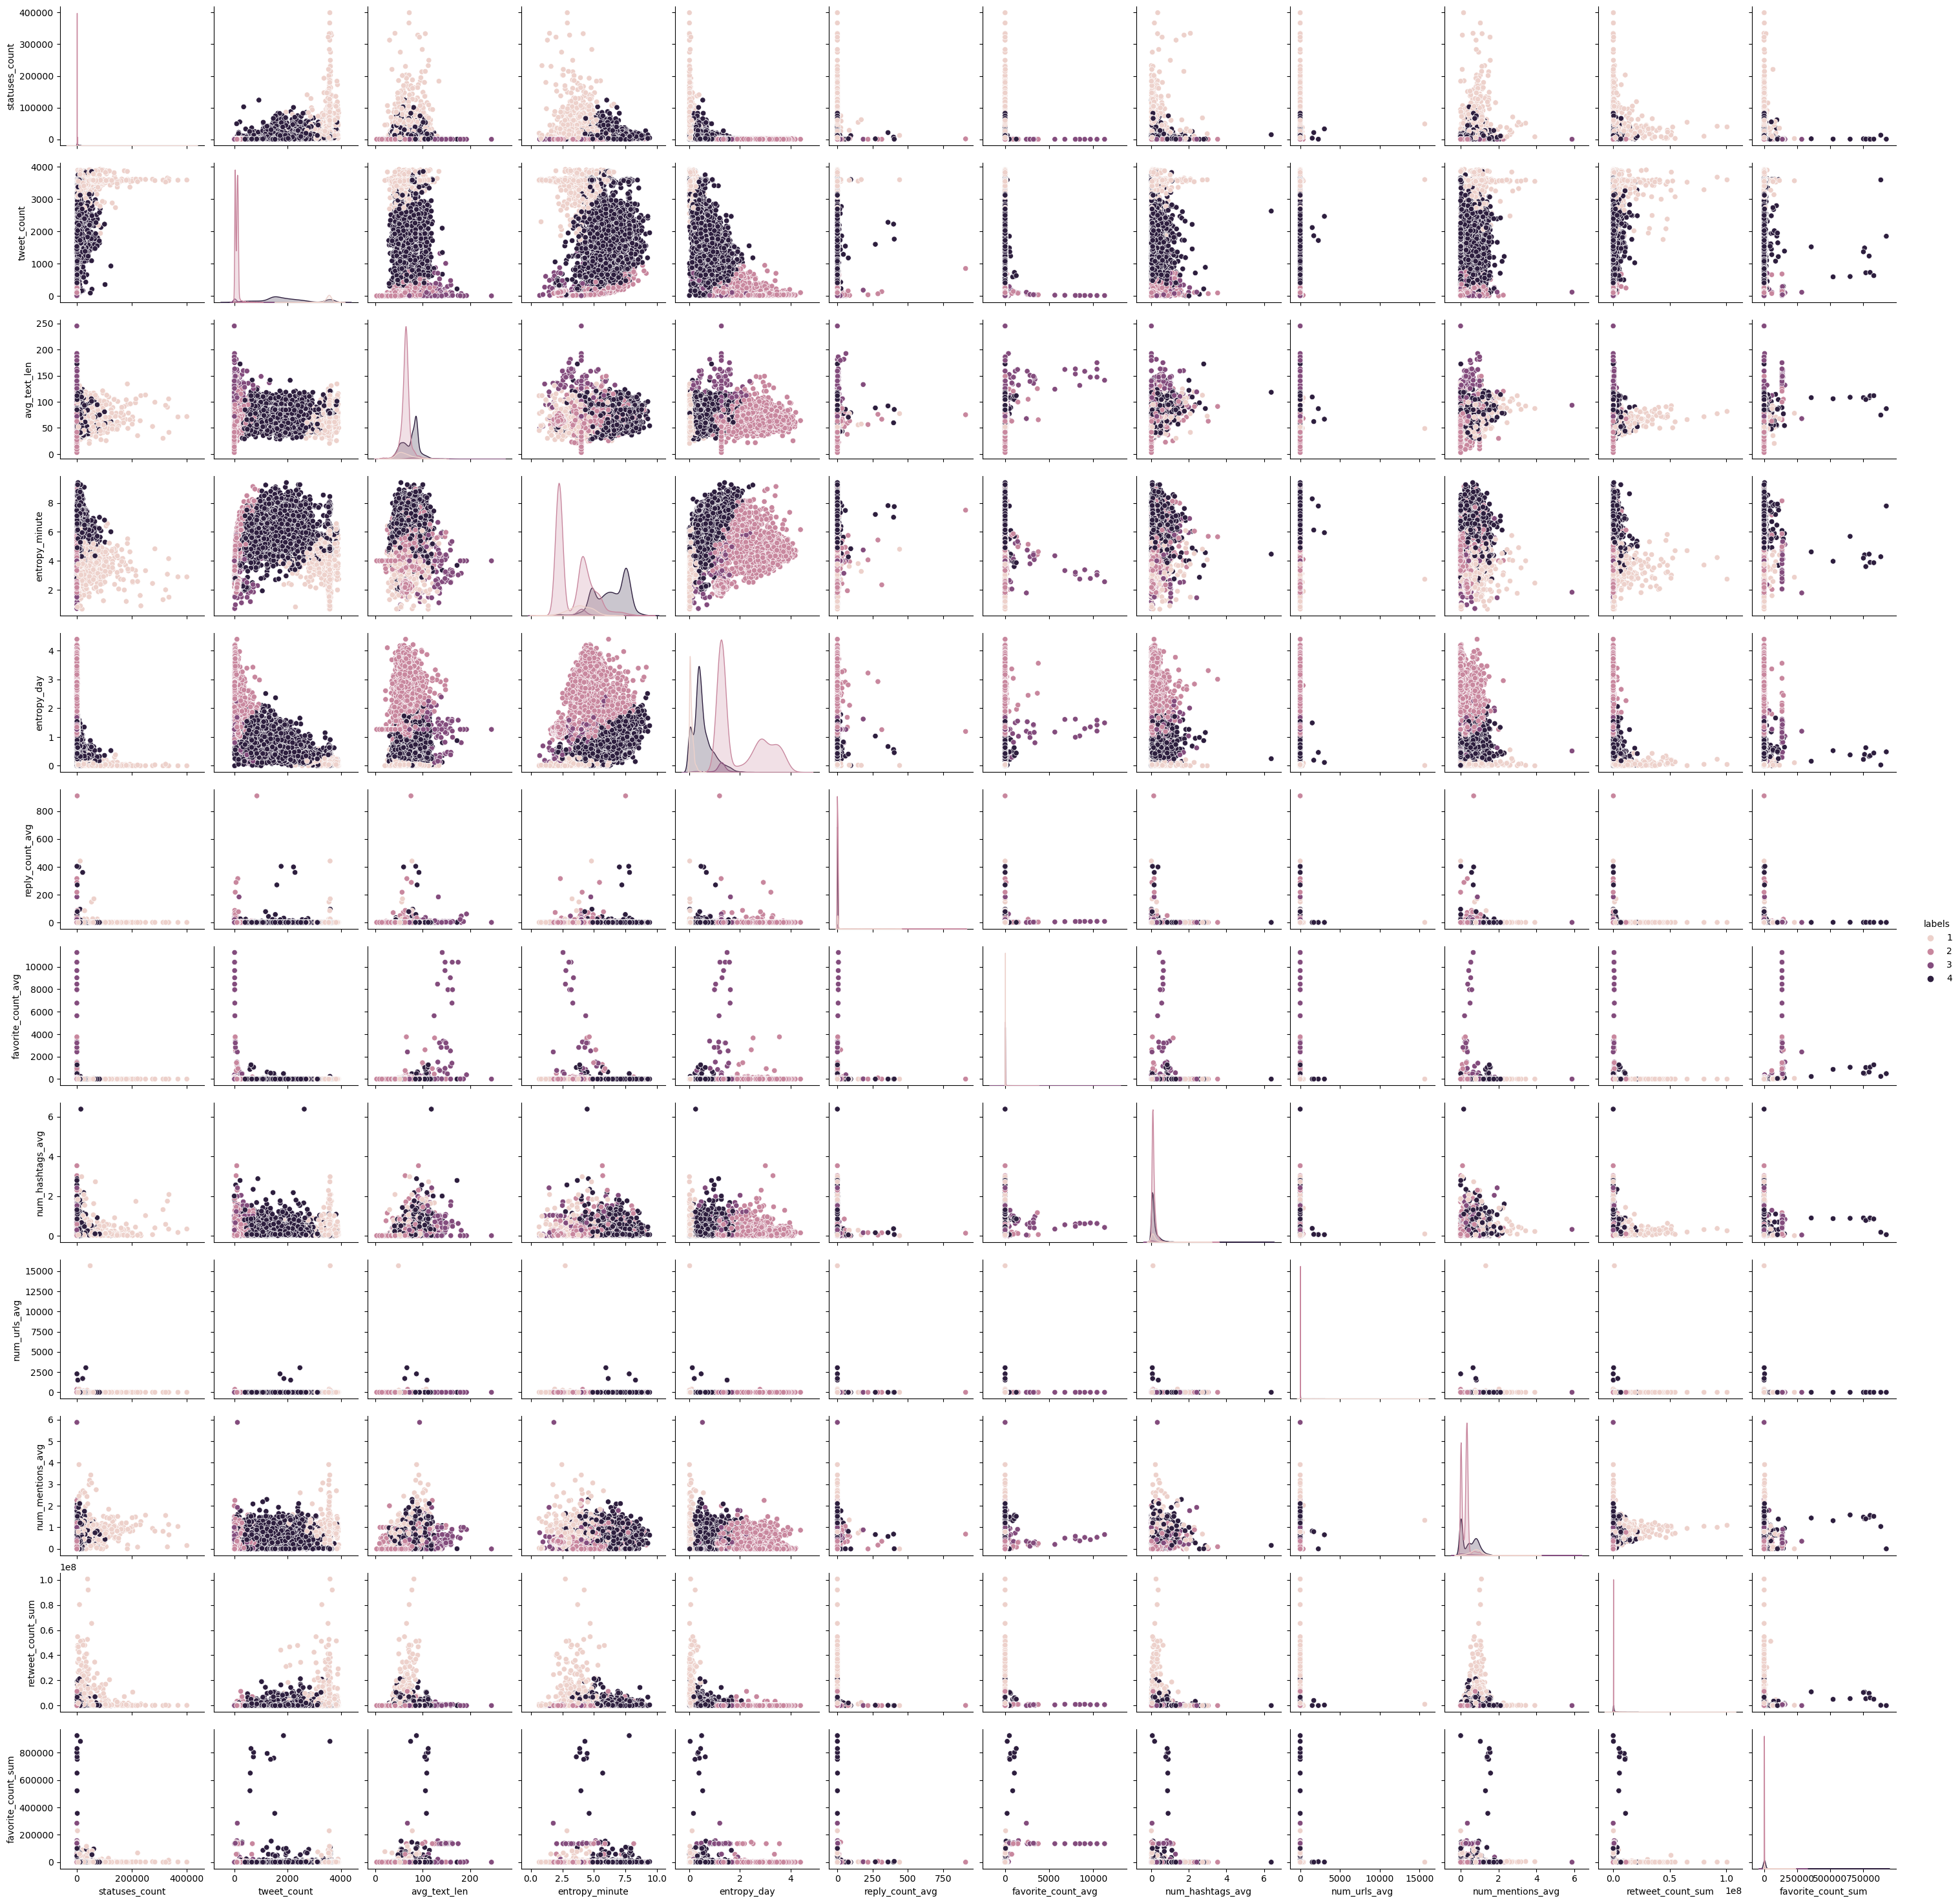

In [ ]:
sns.pairplot(df,hue='labels', palette=sns.color_palette(n_colors=n_clusters))
plt.show()

Bot/non bot distribution for each cluster

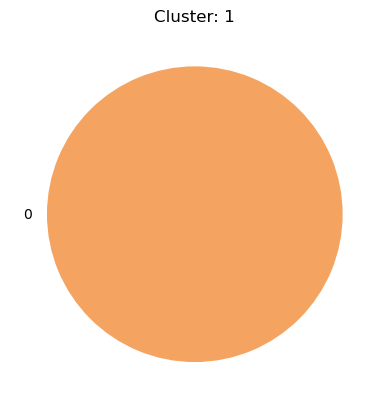

0    4
Name: bot, dtype: int64


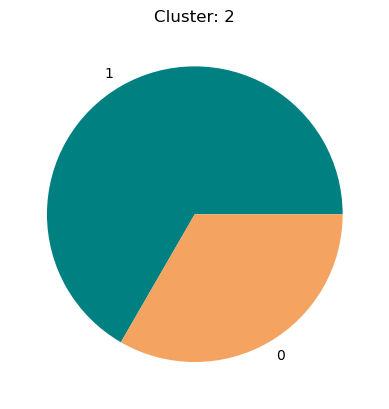

1    2
0    1
Name: bot, dtype: int64


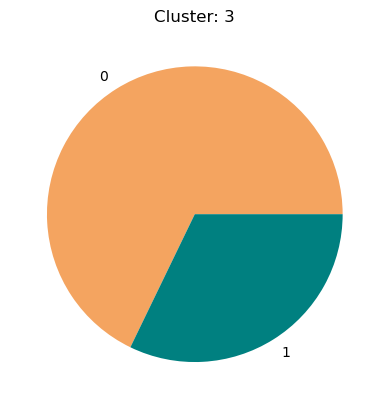

0    3341
1    1585
Name: bot, dtype: int64


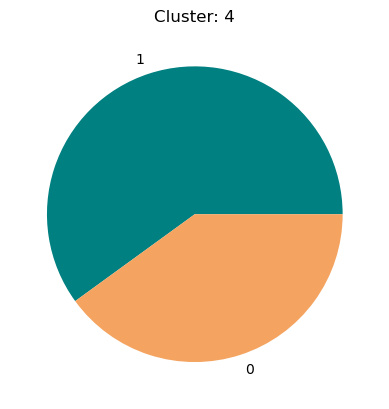

1    3
0    2
Name: bot, dtype: int64


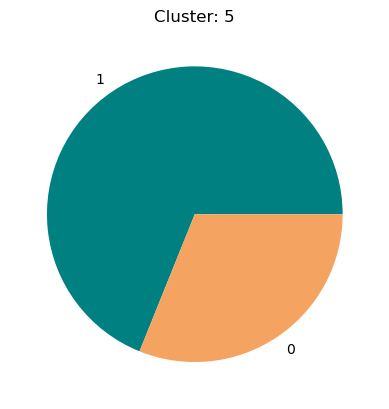

1    4526
0    2043
Name: bot, dtype: int64


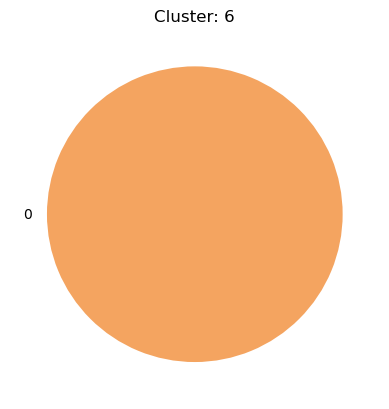

0    1
Name: bot, dtype: int64


In [ ]:
for k in range(1, n_clusters+1):
    # Get 'bot' values for elems in cluster k
    bot_for_cluster = df_bot.loc[hierarchical_final_average_minmax == k].value_counts()
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(bot_for_cluster, labels= bot_for_cluster.index, colors=[dict_colors_bot[v] for v in bot_for_cluster.keys()])
    plt.show()
    print(bot_for_cluster)

#### hierarchical_final_ward_std

In [147]:
n_clusters = len(np.unique(hierarchical_final_ward_std))

Scatter plots

In [148]:
if 'labels' in df.columns:
    del df['labels']
df['labels'] = pd.Series(hierarchical_final_ward_std,index=df.index)

ValueError: Length of values (11016) does not match length of index (11508)

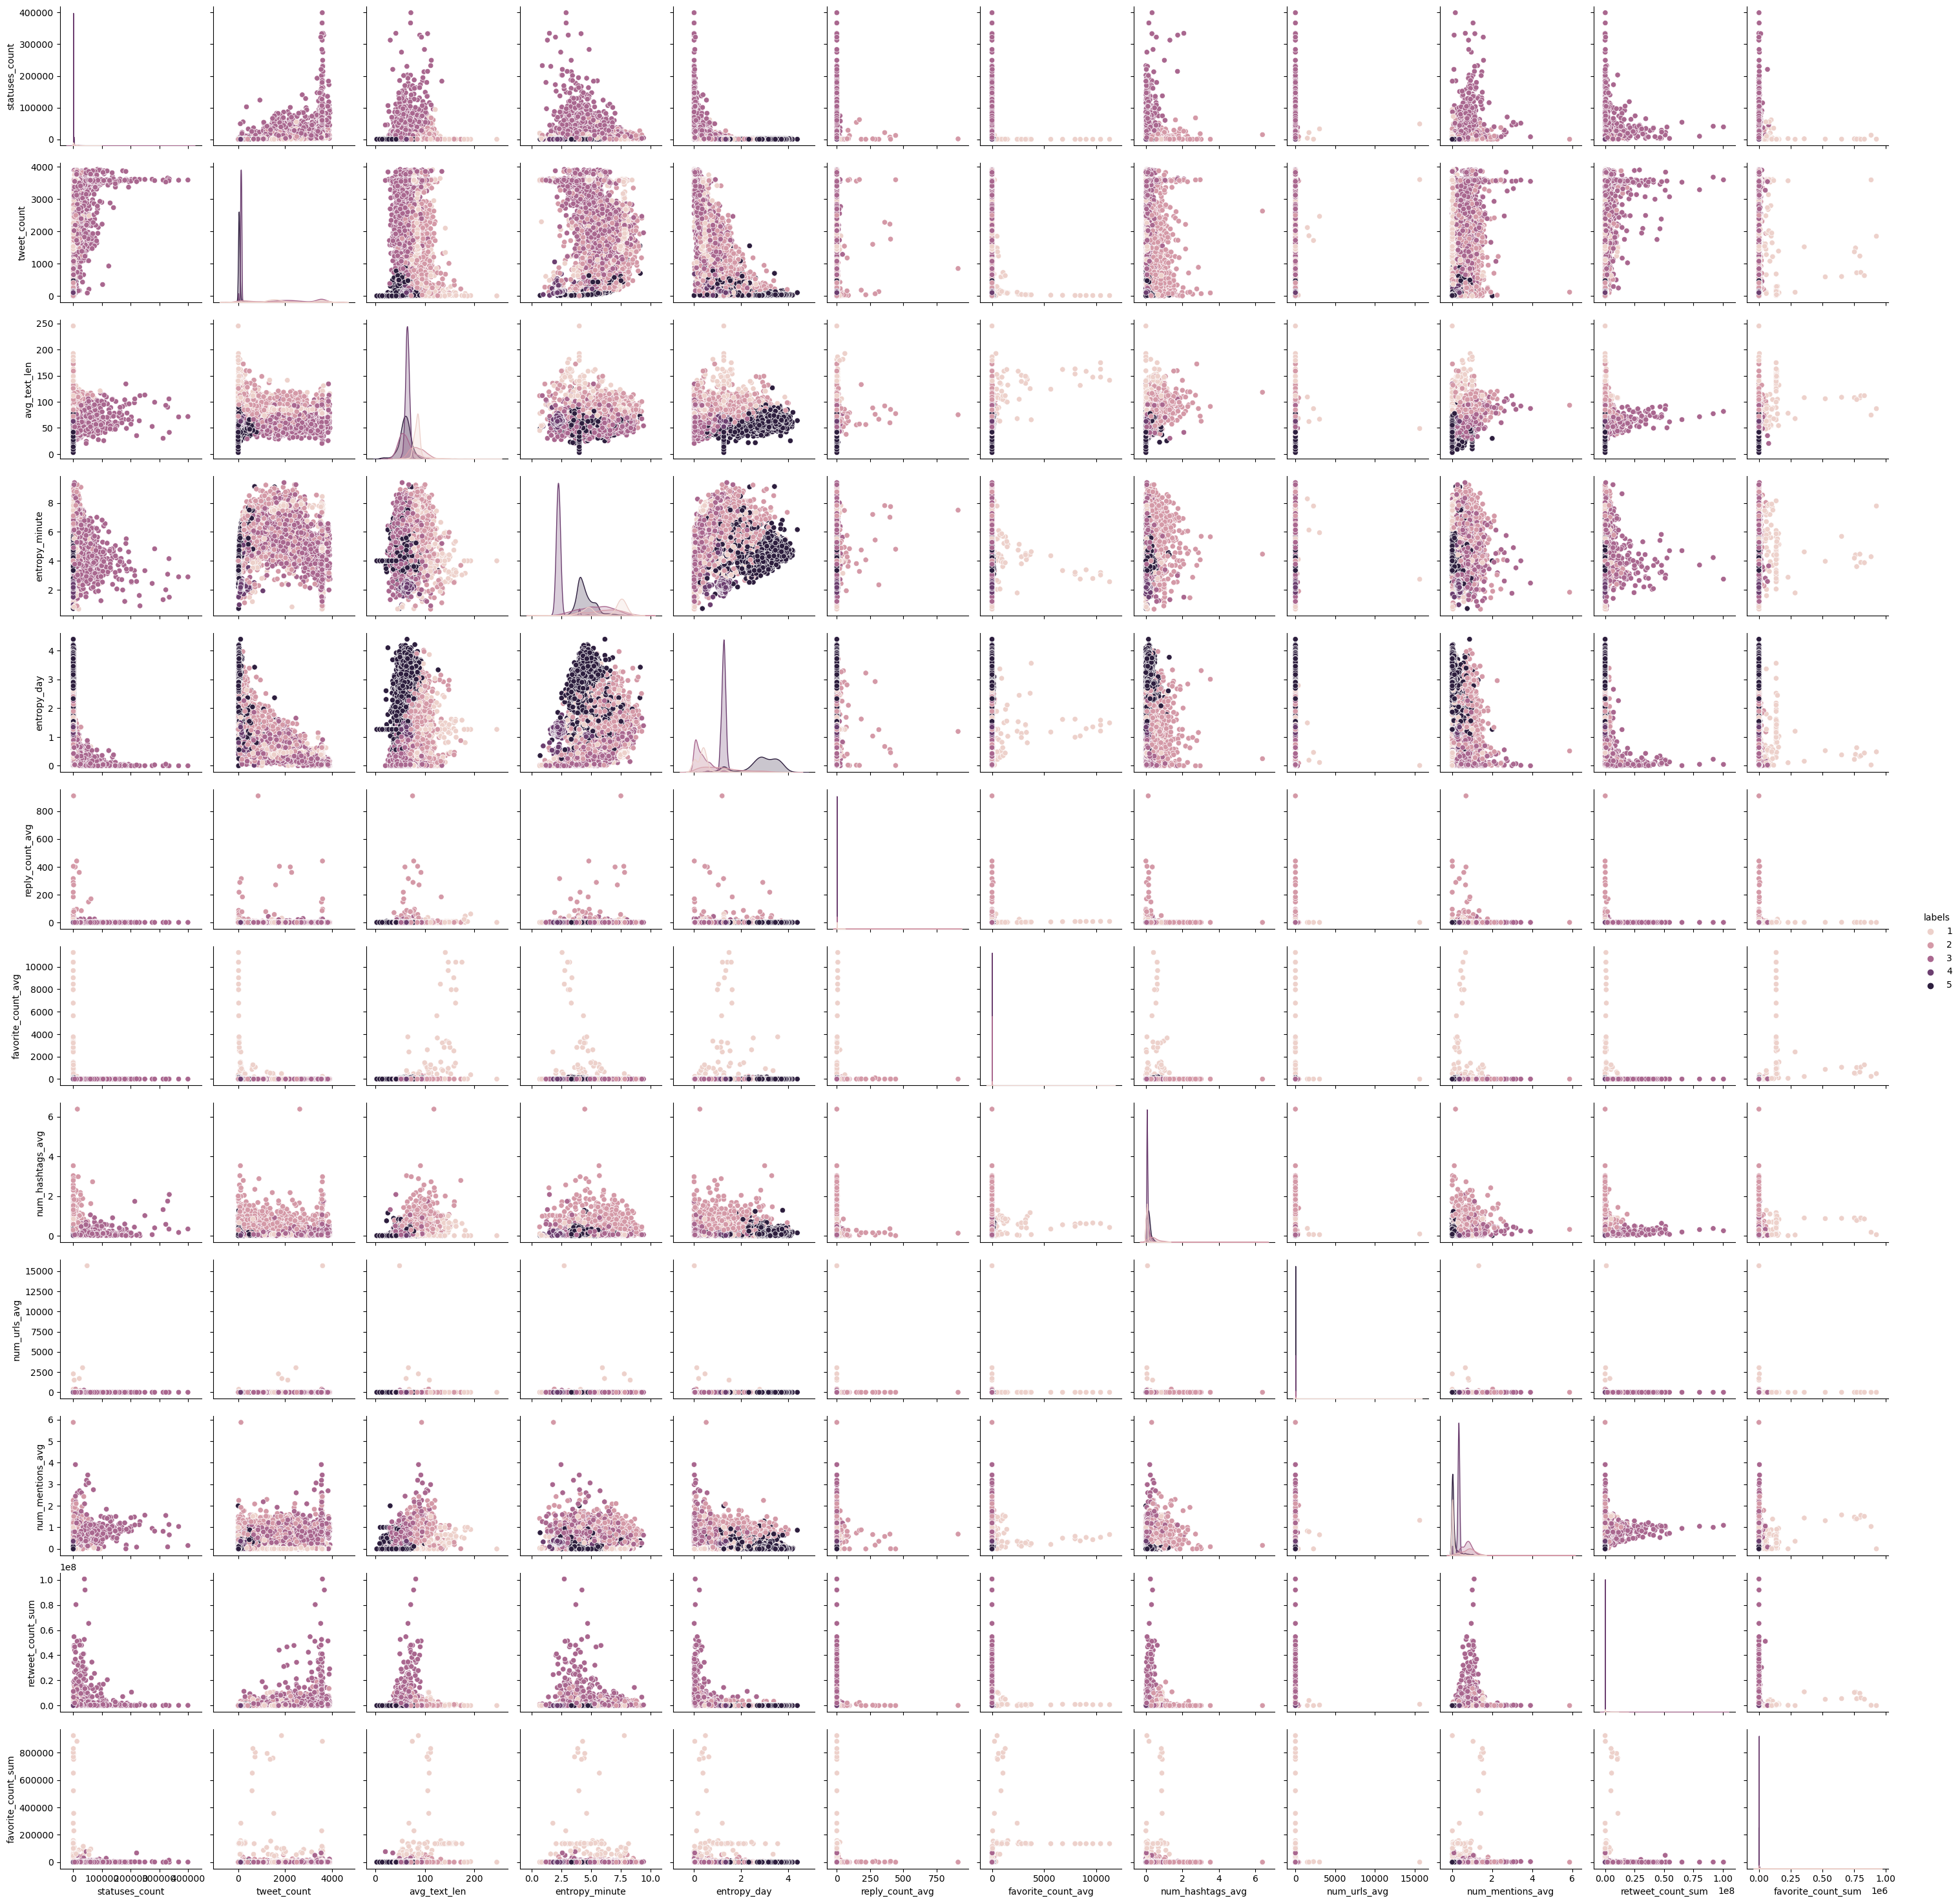

In [ ]:
sns.pairplot(df,hue='labels', palette=sns.color_palette(n_colors=n_clusters))
plt.show()

Bot/non bot distribution for each cluster

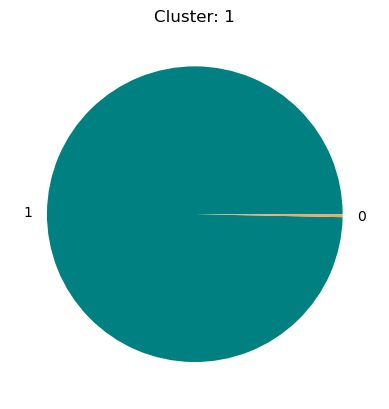

1    1239
0       4
Name: bot, dtype: int64


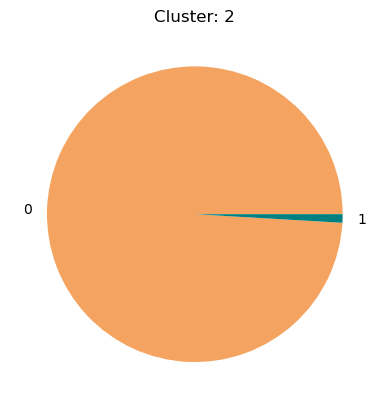

0    1925
1      18
Name: bot, dtype: int64


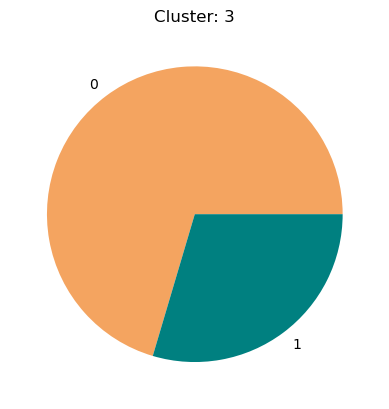

0    1366
1     574
Name: bot, dtype: int64


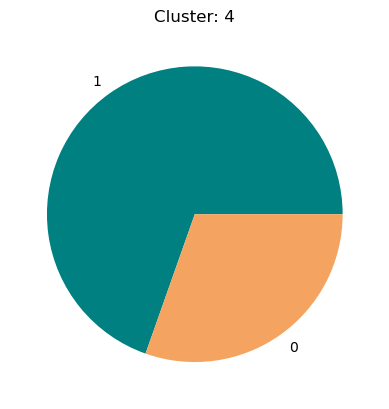

1    2330
0    1018
Name: bot, dtype: int64


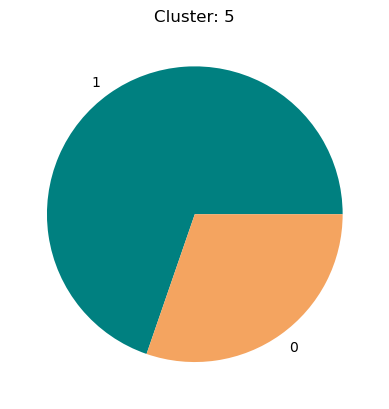

1    1772
0     770
Name: bot, dtype: int64


In [149]:
for k in range(1, n_clusters+1):
    # Get 'bot' values for elems in cluster k
    bot_for_cluster = df_bot_rem_outliers.loc[hierarchical_final_ward_std == k].value_counts()
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(bot_for_cluster, labels= bot_for_cluster.index, colors=[dict_colors_bot[v] for v in bot_for_cluster.keys()])
    plt.show()
    print(bot_for_cluster)

#### hierarchical_final_centroid_std

In [ ]:
n_clusters = len(np.unique(hierarchical_final_centroid_std))

Scatter plots

In [ ]:
if 'labels' in df.columns:
    del df['labels']
df['labels'] = pd.Series(hierarchical_final_centroid_std,index=df.index)

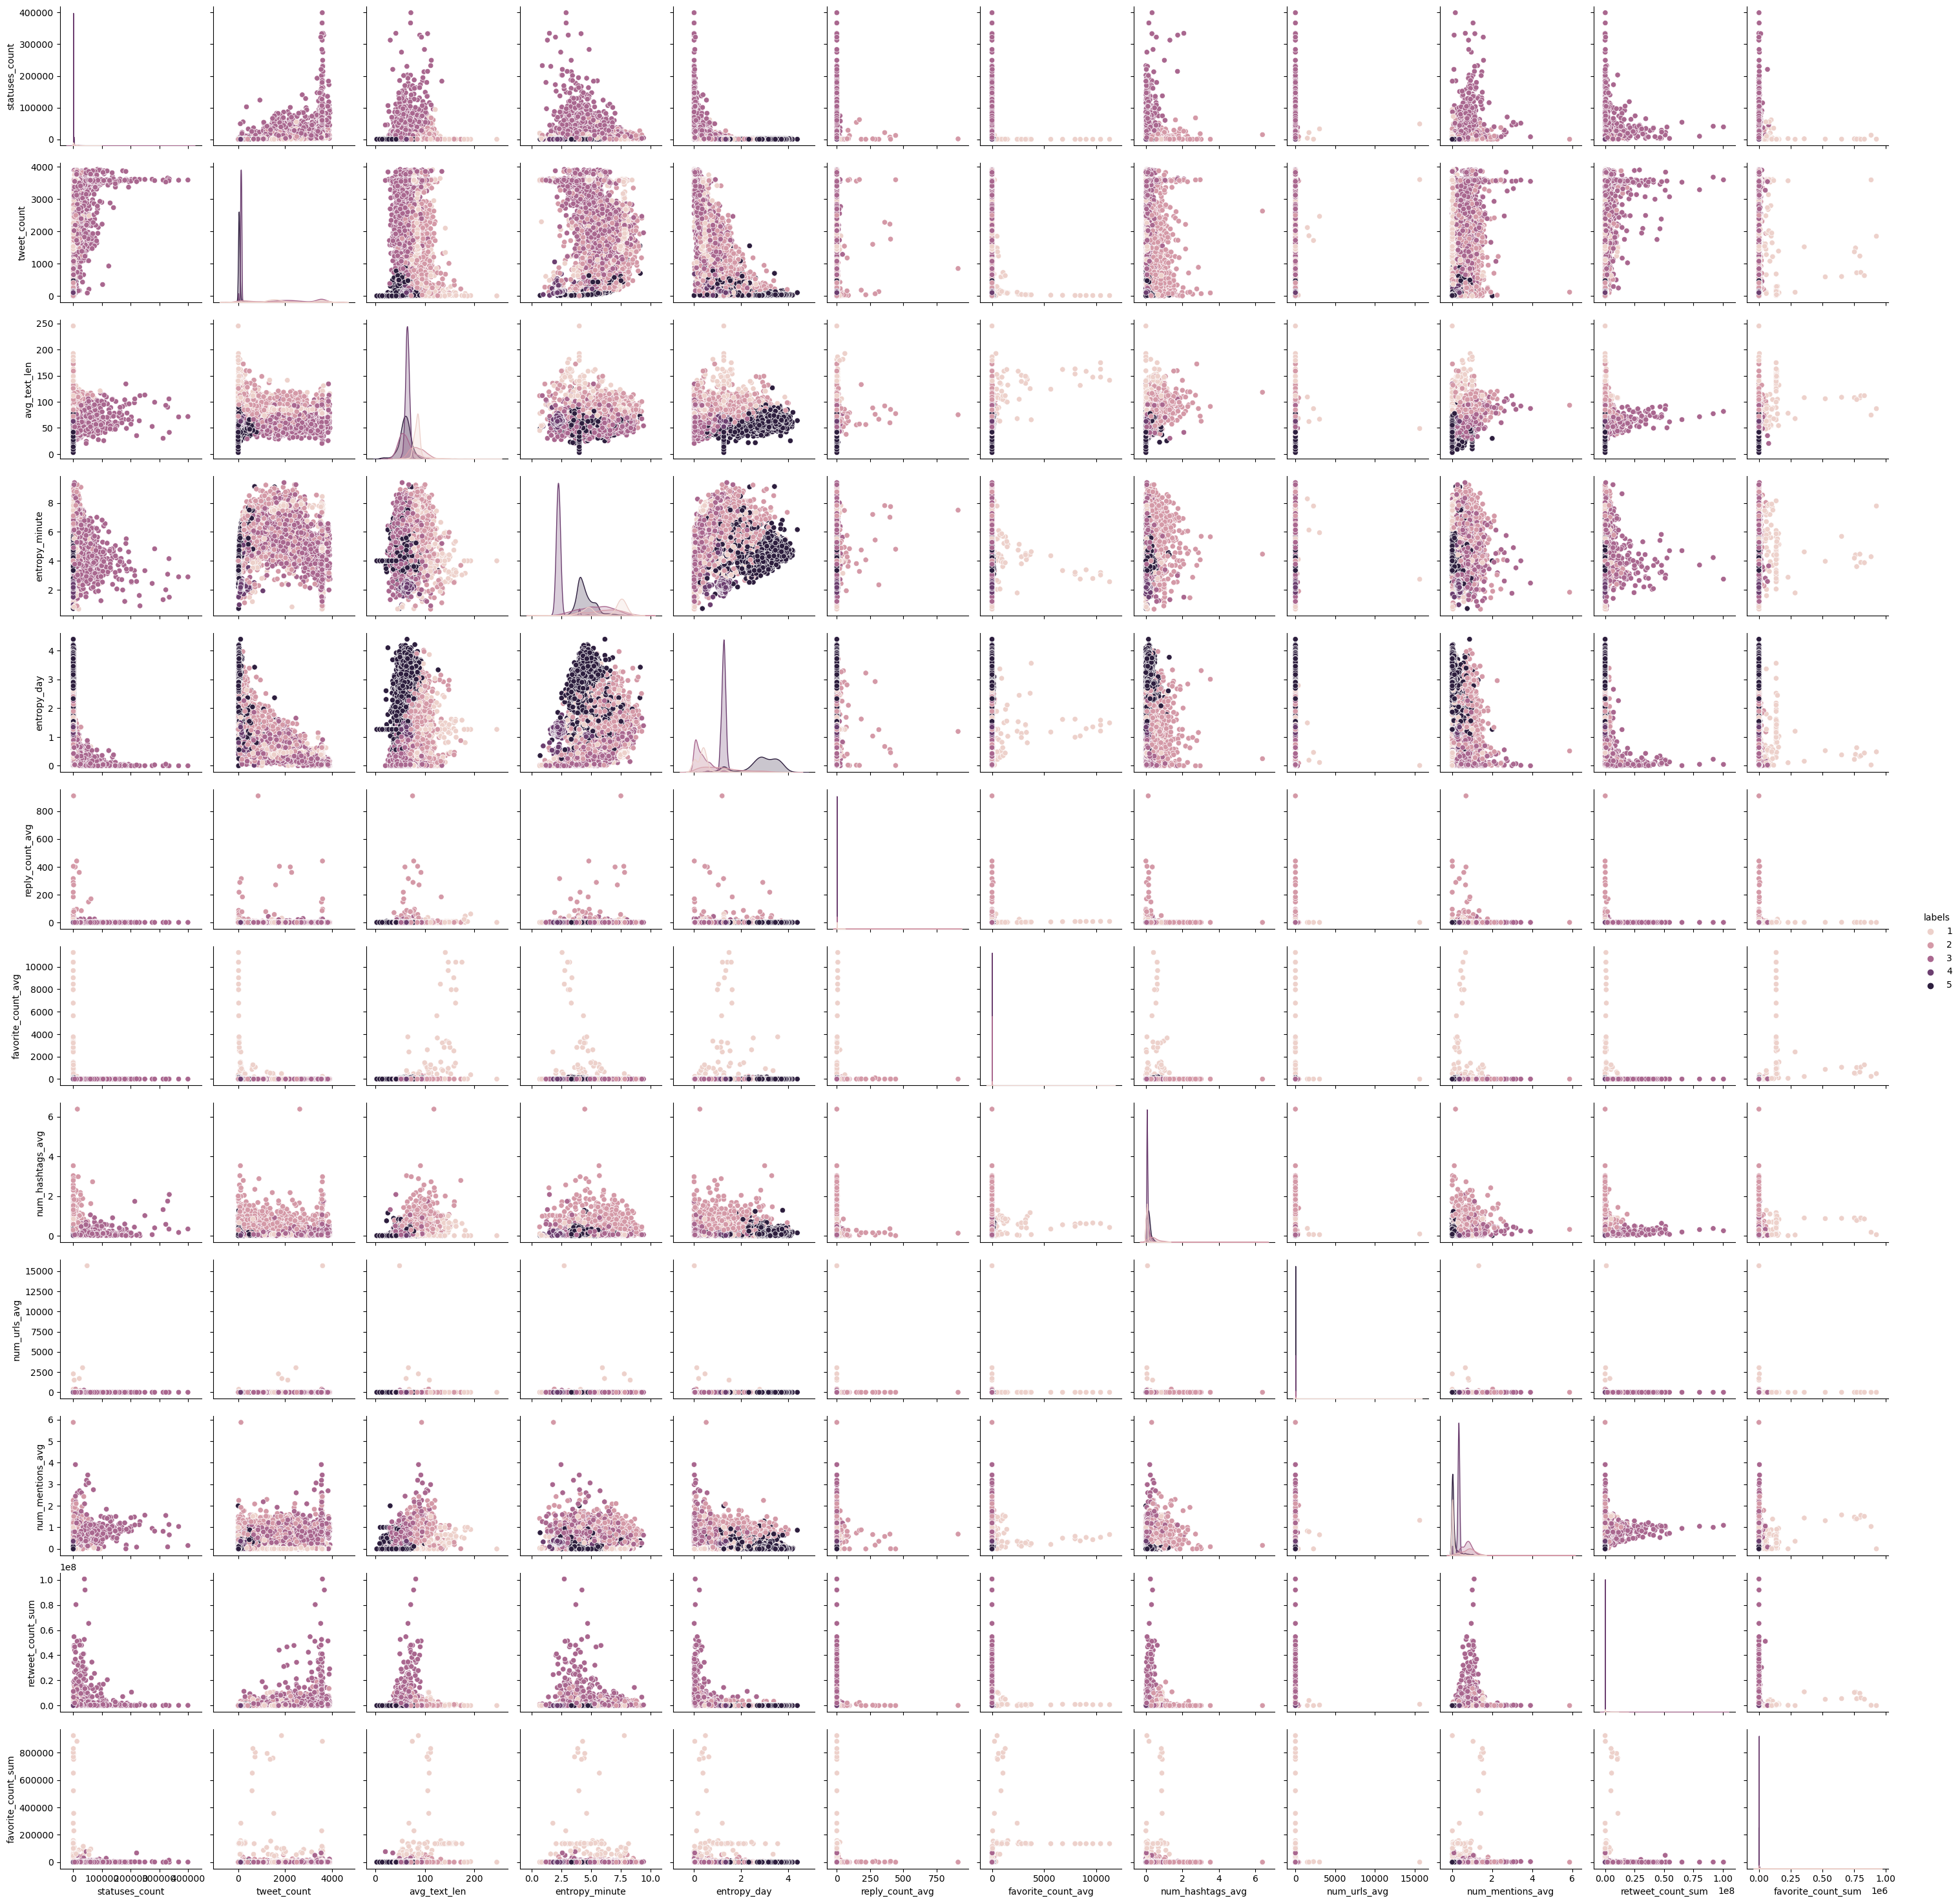

In [ ]:
sns.pairplot(df,hue='labels', palette=sns.color_palette(n_colors=n_clusters))
plt.show()

Bot/non bot distribution for each cluster

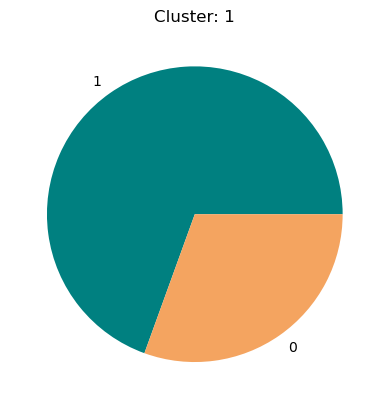

1    4097
0    1801
Name: bot, dtype: int64


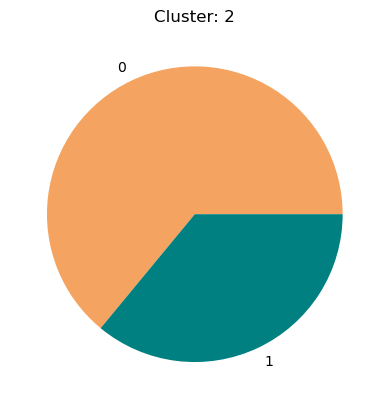

0    3591
1    2019
Name: bot, dtype: int64


In [ ]:
for k in range(1, n_clusters+1):
    # Get 'bot' values for elems in cluster k
    bot_for_cluster = df_bot.loc[hierarchical_final_centroid_std == k].value_counts()
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(bot_for_cluster, labels= bot_for_cluster.index, colors=[dict_colors_bot[v] for v in bot_for_cluster.keys()])
    plt.show()
    print(bot_for_cluster)

TODO EXTRA: clusterizzazione bonus libreria esterna